## Load important Libraries

## Approach


### Cleaning & Preparation
- Removed all the rows (based on their existance in the description columns) with missing values.
- Removed Requirements as it has most of the values missing.
- remove HTML tags from description.
-  concatenate job_title with description.
### Vector Database
- using FAISS to create our vector database.
- using HuggingFaceEmbeddings to create the embeddings.
- sentence-transformers/all-mpnet-base-v2 as my embedding model.
- break it into chuncks each of size 1000 characters with no overlap.

### Chain
- build a prompt that forces the model to give and advice and arange them in steps or bullet points.
- using quantized (microsoft/Phi-3-mini-4k-instruct) to generate responses.
- retrieve chucks that are most similar to the query.
- (prompt + LLm + retrieved samples) --> Response.

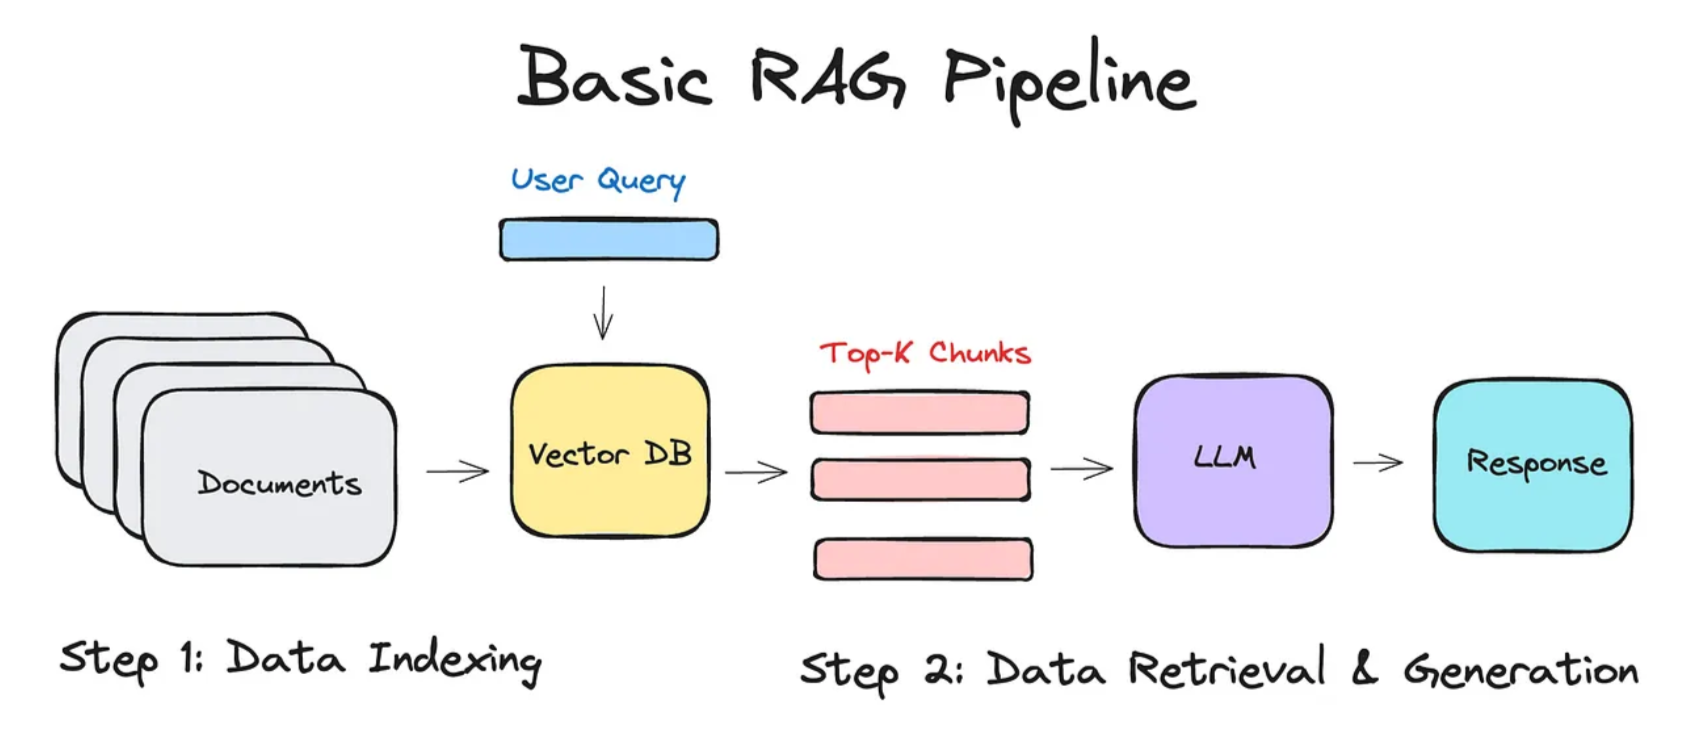




In [3]:
# !pip install llama-index llama-index-llms-huggingface llama-index-embeddings-huggingface transformers accelerate bitsandbytes llama-index-readers-web matplotlib flash-attn
# !pip install -q -U langchain playwright sentence_transformers faiss-gpu
# !pip install -q torch datasets
# !pip install -q accelerate peft bitsandbytes trl
# !pip install -U langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 52.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 98.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline
)

from langchain.chains.question_answering import load_qa_chain
import transformers
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline
)
from datasets import load_dataset
from peft import LoraConfig, PeftModel

from langchain.text_splitter import CharacterTextSplitter, NLTKTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader, DataFrameLoader

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS, Chroma

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



## Load Generation Model

In [5]:
# bitsandbytes parameters


# Activate 4-bit precision
use_4bit = True
# Compute dtype for 4-bit
bnb_4bit_compute_dtype = 'float16'
# Quantization type
bnb_4bit_quant_type = 'nf4'
# Activate nested quatization for 4-bit base model
use_nested_quant = False

In [6]:
import torch
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit = use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [19]:
## Load quantized Phi-3
model_name = 'microsoft/Phi-3-mini-4k-instruct'
llm = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config = bnb_config)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code= True)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def print_number_of_trainable_parameters(model):
    """ return number of trainable parameters and total number of parameters

    input:
        model
    return:
        trainable parameters and total number of parameters
    """
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
        return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"
print(print_number_of_trainable_parameters(llm))

trainable model parameters: 98500608
all model parameters: 98500608
percentage of trainable model parameters: 100.00%


### Creating Generation Pipeline

In [20]:
text_generation_pipeline = pipeline(
    model = llm,
    tokenizer = tokenizer,
    task = 'text-generation',
    temperature = 0.2,
    repetition_penalty = 1.1,
    return_full_text = True,
    max_new_tokens = 1000)

In [21]:
llm = HuggingFacePipeline(pipeline = text_generation_pipeline)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


## Load and Clean Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Engineer 2024 Task and Data/sampled_jobs.csv')

In [9]:
import re

def remove_html_tags(text):
    # Define a regex pattern to match HTML tags
    clean = re.compile('<.*?>')
    # Substitute the matched HTML tags with an empty string
    text = re.sub(clean, '', text)
    text = text.replace('\n', ' ')
    return text

df['description'] = df['description'].apply(remove_html_tags)

In [10]:
# drop requirements columns as it has a lot of missing values
df.drop('requirements', axis=1,inplace = True)

In [11]:
# drop rows where there is missing values in the description columns
index_drop = df[df['description'] == ''].index
df.drop(index_drop, axis= 0, inplace=True)

In [12]:
# concatenate job_title with description
df['Docs'] = df['job_title'] + ': ' + df['description']

In [13]:
df.drop(['job_title', 'description', 'career_level'], axis=1, inplace=True)
# df.to_csv('/kaggle/working/ready_df.csv', index=False)

### Vector Database

In [14]:
## dataframeloader
df_loader = DataFrameLoader(df, page_content_column= 'Docs')
data_df_l = df_loader.load()

In [15]:
documents = [data_df_l[i].page_content for i in range(len(data_df_l))]

# # split the doc into smaller chunks i.e. chunk_size=1000
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
tokens_chunks = text_splitter.create_documents(
    documents,
)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
model_kwargs = {'device': device}
encode_kwargs = {'normalize_embeddings': False}
# Embedding model
embedding_llm = HuggingFaceEmbeddings(model_name ='sentence-transformers/all-mpnet-base-v2',
                                              model_kwargs=model_kwargs,
                                               encode_kwargs=encode_kwargs)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
# Load chunked documents into FAISS index
db = FAISS.from_documents(tokens_chunks, embedding_llm)

retriever = db.as_retriever()

In [29]:
query_text = "How to be a Machine Learning Engineer?"

similar_docs = db.similarity_search(query_text, k=3)
similar_docs[0]

Document(page_content="AI & ML Engineer: Job Description: AI & ML EngineerResponsibilities:Develop and implement AI & ML algorithms and models to solve complex business problems and improve efficiency.Design and build AI & ML systems for data processing, data storage, and data visualization.Collaborate with cross-functional teams to integrate AI & ML solutions into existing systems and processes.Conduct research and stay updated on the latest trends and advancements in AI & ML technology.Perform data cleansing, preprocessing, and feature engineering to prepare data for AI & ML modeling.Validate and optimize AI & ML models to ensure accuracy, efficiency, and scalability.Document development processes, results, and recommendations for future improvements.Requirements:Bachelor's or Master's degree in Computer Science, Mathematics, Data Science, or related field.Minimum of 3 years of experience in AI & ML development, preferably in a business setting.Proficient in programming languages suc

### Prompt Template

In [23]:
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<>\n", "\n<>\n\n"
DEFAULT_SYSTEM_PROMPT = """\
You are a Career Advicer who give advice to people about what are the requirements, tools or
technologies they should learn to get a certain job. please be more specific and accurate as possible.
"""


In [24]:
def get_prompt(instruction, new_system_prompt=DEFAULT_SYSTEM_PROMPT, citation=None):
  """
    reconstract the prompt so that it has the correct/better system prompt and instruction
  """
    SYSTEM_PROMPT = B_SYS + new_system_prompt + E_SYS
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST

    return prompt_template

def cut_off_text(text, prompt):
  """
    remove unneeded text from the generated text
  """
    cutoff_phrase = prompt
    index = text.find(cutoff_phrase)
    if index != -1:
        return text[:index]
    else:
        return text

def remove_substring(string, substring):
    return string.replace(substring, "")

In [36]:
system_prompt = "You are Career Advicer that excels at giving advice. "
instruction = """Convert the following input text to a step-by-step throughout advice:\n\n {context}
\n\n
### Question: {question}
\n\n
### Answer:,
"""
template = get_prompt(instruction, system_prompt)
print(template)

[INST]<>
You are Career Advicer that excels at giving advice. 
<>

Convert the following input text to a step-by-step throughout advice:

 {context}



### Question: {question}



### Answer:,
[/INST]


In [26]:
prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"],
    )

## Chain

In [35]:
llm_chain = LLMChain(llm = llm, prompt= prompt)

In [40]:
rag_chain = (
    {'context': retriever, 'question': RunnablePassthrough()}
    | llm_chain
)

result = rag_chain.invoke('How to be a Machine Learning Engineer?')

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [41]:
result['text']

'[INST]<>\nYou are Career Advicer that excels at giving advice. \n<>\n\nConvert the following input text to a step-by-step throughout advice:\n\n [Document(page_content="AI & ML Engineer: Job Description: AI & ML EngineerResponsibilities:Develop and implement AI & ML algorithms and models to solve complex business problems and improve efficiency.Design and build AI & ML systems for data processing, data storage, and data visualization.Collaborate with cross-functional teams to integrate AI & ML solutions into existing systems and processes.Conduct research and stay updated on the latest trends and advancements in AI & ML technology.Perform data cleansing, preprocessing, and feature engineering to prepare data for AI & ML modeling.Validate and optimize AI & ML models to ensure accuracy, efficiency, and scalability.Document development processes, results, and recommendations for future improvements.Requirements:Bachelor\'s or Master\'s degree in Computer Science, Mathematics, Data Scienc

In [52]:
qna_template = "\n".join([
    "Answer the next question using the provided context.",
    "Convert the following input text to a step-by-step throughout advice",
    "### Context:",
    "{context}",
    "",
    "### Question:",
    "{question}",
    "",
    "### Answer:",
])

qna_prompt = PromptTemplate(
    template=qna_template,
    input_variables=['context', 'question'],
    verbose=False
)

stuff_chain = load_qa_chain(llm, chain_type="stuff", prompt=qna_prompt)


In [43]:
# question = "Why did Tesla work as a football player?"
question = "How can I fit for a Machine Learning Engineer role?"
# similar_docs


similar_docs = db.similarity_search(question, k=3)

print(len(similar_docs))

3


In [44]:
answer = stuff_chain(
    {
        "input_documents": similar_docs,
        "question": question
    },
    return_only_outputs=True,
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [48]:
answer['output_text']

"Answer the next question using the provided context.\nConvert the following input text to a step-by-step throughout advice\n### Context:\nMachine Learning Engineer: Showcase your software engineering talents using ML-powered profiles. Loved by 11k+ engineers! Backed by Antler.The RoleYou Will Be Responsible ForDeveloping scripts to process structured and unstructured data.Recommending, developing and implementing ways to improve data reliability, efficiency and quality.Supporting translation of data business needs into technical system requirements.Working with stakeholders to understand needs in order with respect to data structure, availability, scalability and accessibility.Developing high-quality code to build and deploy machine learning models.Ideal ProfileYou possess a degree in Computer Science, Applied Mathematics, Engineering or related field.You have at least 1 year experience, ideally within a Data Engineer role.Demonstrated experience working with large and complex data se

## Evaluation

### Test 1

In [28]:
rag_chain = (
    {'context': retriever, 'question': RunnablePassthrough()}
    | llm
)


text = "How to be a Machine Learning Engineer?"
response = rag_chain.invoke(text)

# result = rag_chain.invoke('How to be a Machine Learning Engineer?')

ValueError: Invalid input type <class 'dict'>. Must be a PromptValue, str, or list of BaseMessages.

In [ ]:
print(response)

[INST]<>
You are Career Advicer that excels at giving advice. 
<>

Convert the following input text to a step-by-step throughout advice:

 How to be a Machine Learning Engineer?[/INST] To become a successful machine learning engineer, follow these steps for guidance and career development:

1. **Educational Foundation**: Start with obtaining strong foundations in mathematics (calculus, linear algebra), computer science, statistics, and programming languages like Python or R which are commonly used in ML projects. Consider pursuing an undergraduate degree in Computer Science, Mathematics, Statistics, Data Analytics, or related fields if you haven't already done so. Alternatively, take online courses from platforms such as Coursera, edX, Udacity, etc., focusing on relevant subjects mentioned above.

2. **Specialize Your Skills**: Once your educational foundation is set up, specialize by gaining hands-on experience through personal project work or internships wherein you can apply theoret

### Test 2

In [ ]:
text2 = "How to be a Frontend Developer?"
response2 = llm_chain.run(text2)

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
print(response2)

[INST]<>
You are Career Advicer that excels at giving advice. 
<>

Convert the following input text to a step-by-step throughout advice:

 How to be a Frontend Developer ?[/INST] To become a proficient frontend developer, follow these steps for structured guidance and skill development in your career journey:

1. **Educational Foundation**: Start with learning HTML (HyperText Markup Language) as it is the backbone of web content structure. Follow this by mastering CSS (Cascading Style Sheets), which allows you to style websites visually. JavaScript will enable interactivity on web pages; learn its core concepts along with frameworks like React or Angular if interested in modern full stack applications.

2. **Practice Coding Regularly**: Use online resources such as Codecademy, W3Schools, or freeCodeCamp to practice coding skills through interactive lessons. Build small projects from scratch using tools like Visual Studio Code or Sublime Text to apply what you've learned practically.

3